In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from sklearn.model_selection import KFold
from sklearn import linear_model
from sklearn import preprocessing as preproc # load preprocessing function
import warnings
warnings.filterwarnings("ignore")
sns.set()
from sklearn import tree
from sklearn import ensemble


# Todo

## Time series
1. Gennemsnittet for de sidste N observationer per destination
2. Gennemsnittet for de sidste N søndage (og lørdage, mandage etc) eller bare delt op på hverdag/weekend
3. Kombi af 1. og 2. 




## Categorical
1. Tidspunkt på dagen 
2. Weekend/hverdag i stedet for ugedage

## "Weighted least squares "
1. Optimer den procentvise andel af data der bliver brugt (MSE) 

## Include more 
- Seatcapacity 
- Airline type 
- etc.

## Model parametre i Random forrest/regression trees
- m: number of variables to consider in each split. Good idea to tune it. But we can also use floor(p/3) for regression. When we use a subset to choose from in each split, we obtain the bagging variance, which is nice and which gives us the uncorrelated trees
- When there is too many variables that are not important, it lowers the performance 

## BIC og AIC for decision tree
- oob

## Feature selection 




In [24]:
# read data
data = pd.read_excel("data/realised_schedule.xlsx")




## Data

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


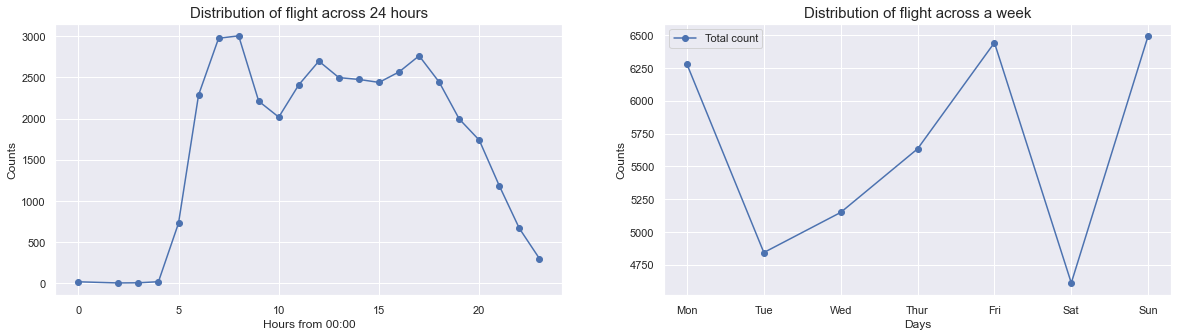

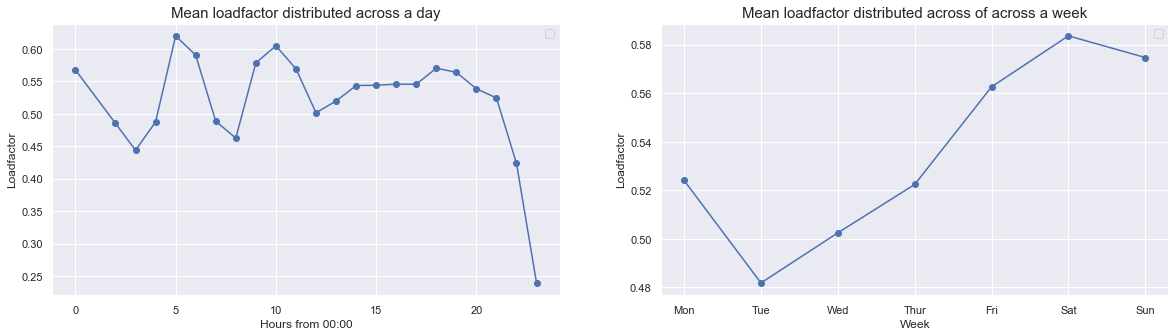

In [25]:
fig, ax = plt.subplots(1,2, figsize = (20,5))
ax[0].plot(data.groupby(data["ScheduleTime"].dt.hour).count().LoadFactor, 'o-')
ax[0].set_title('Distribution of flight across 24 hours', fontsize = 15)
ax[0].set_xlabel('Hours from 00:00')
ax[0].set_ylabel('Counts')

ax[1].plot(data.groupby(data["ScheduleTime"].dt.weekday).count().LoadFactor, 'o-', label = 'Total count')
ax[1].set_title('Distribution of flight across a week', fontsize = 15)
ax[1].set_xlabel('Days')
ax[1].set_xticks(np.arange(0,7), ['Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun'])
ax[1].set_ylabel('Counts')
ax[1].legend()

################################

fig, ax = plt.subplots(1,2, figsize = (20,5))


ax[0].plot(data.groupby(data["ScheduleTime"].dt.hour).mean().LoadFactor, 'o-')
ax[0].set_title('Mean loadfactor distributed across a day', fontsize = 15)
ax[0].set_xlabel('Hours from 00:00')
#ax[1].set_xticks(np.arange(0,7), ['Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun'])
ax[0].set_ylabel('Loadfactor')
ax[0].legend()


ax[1].plot(data.groupby(data["ScheduleTime"].dt.weekday).mean().LoadFactor, 'o-')
ax[1].set_title('Mean loadfactor distributed across of across a week', fontsize = 15)
ax[1].set_xlabel('Week')
ax[1].set_xticks(np.arange(0,7), ['Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun'])
ax[1].set_ylabel('Loadfactor')
ax[1].legend()




plt.show()


## Analysing data

The plots above indicates that both day of week and time of day is important features to include

# Features

Categorical (for one-hot-encoding):
- Destination
- Airline
- Sector
- Flight type

Added categorical
- Weekday
- Hour of day

Continious
- Seat capacity 

Nessesary for additional features
- ScheduleTime
  
Time series (missing is replaced with mean value of some sort. For know it is the mean training oadfactor in general):
1. Destination
2. Sector
3. Airline 
4. Mean of last week 
5. Mean of last hour

y
- load factor

# Create variables

In [26]:
# choose rows of interrest
#data = df

## Modify features 

# Choose which features to use 
data = data[['Destination','Sector','FlightType','SeatCapacity','ScheduleTime','LoadFactor', 'Airline']] #''
data_ = data[[ 'Destination','Sector','FlightType','Airline' ]] # Airline

# Weekday features
data['weekday']=data['ScheduleTime'].dt.day_of_week 
data['week_day'] = data.weekday.apply(lambda x: str(x)) # string formatting nessesary for one-hot-encoding

# Hour feature
data['hour']= data['ScheduleTime'].dt.hour 
data['hour'] = data.hour.apply(lambda x: str(x))


# Hours from first observation 
#time = (data.ScheduleTime - data.ScheduleTime.iloc[0]) /pd.Timedelta('1 hour') # substract time for first obs. and divide by hour
#min_ = time.min() 
#max_ = time.max()
#time =  (time - min_) / (max_ - min_) # min-max normalisation 
#data['time'] = time

# One hot encoding 
data = pd.get_dummies(data)

# Add variables which where expanded 
data = pd.concat([data, data_], axis=1)






# Create time series variables


In [27]:
# create timeseries for training data
replacer_mu = data[data['ScheduleTime'] < '2022-02-01'].LoadFactor.mean()

new = ['time_prev_destination','time_prev_sector']#, 'time_prev_airline']
original = ['Destination', 'Sector']#, 'Airline']

for i, j in zip(new,original):  

# time_prev_destination
    data[i] = data.groupby(j)['LoadFactor'].shift()


data = data.fillna(replacer_mu)


# create timeseries for training data
#replacer_mu = data[data['ScheduleTime'] < '2022-02-01'].LoadFactor.mean()

#new = ['time_prev_destination','time_prev_sector']#, 'time_prev_airline']
#original = ['Destination', 'Sector']#, 'Airline']

#for i, j in zip(new,original):  
# time_prev_destination
#    data[i] = data.groupby(j)['LoadFactor'].shift()


#data = data.fillna(replacer_mu)




In [28]:
# split into val and training data
val_data = data[data['ScheduleTime'] >='2022-02-01']
train_data = data[data['ScheduleTime'] < '2022-02-01']

In [29]:
#np.expand_dims(val_data.iloc[0].values, axis = 1).T.shape

In [30]:
#new_obs = pd.DataFrame(columns = val_data.iloc[0].index, data = np.expand_dims(val_data.iloc[0].values, axis = 1).T)

#train_data['Destination']  == new_obs.Destination.values[0]



In [31]:
# access relevant variables. That is, drop variables that are already one-hot-encoded 
# (but saved because we need them in order to get time series variables)

y_val = val_data.LoadFactor.values
X_val = val_data.drop(['Airline', "LoadFactor", 'ScheduleTime', 'Destination','Sector','FlightType'], axis = 1).values #

y_train = train_data.LoadFactor.values
X_train = train_data.drop(['Airline', "LoadFactor", 'ScheduleTime', 'Destination','Sector','FlightType'], axis = 1).values # 


Model absolute error: 0.18731124154273487
Baseline error: 0.2824613007967415


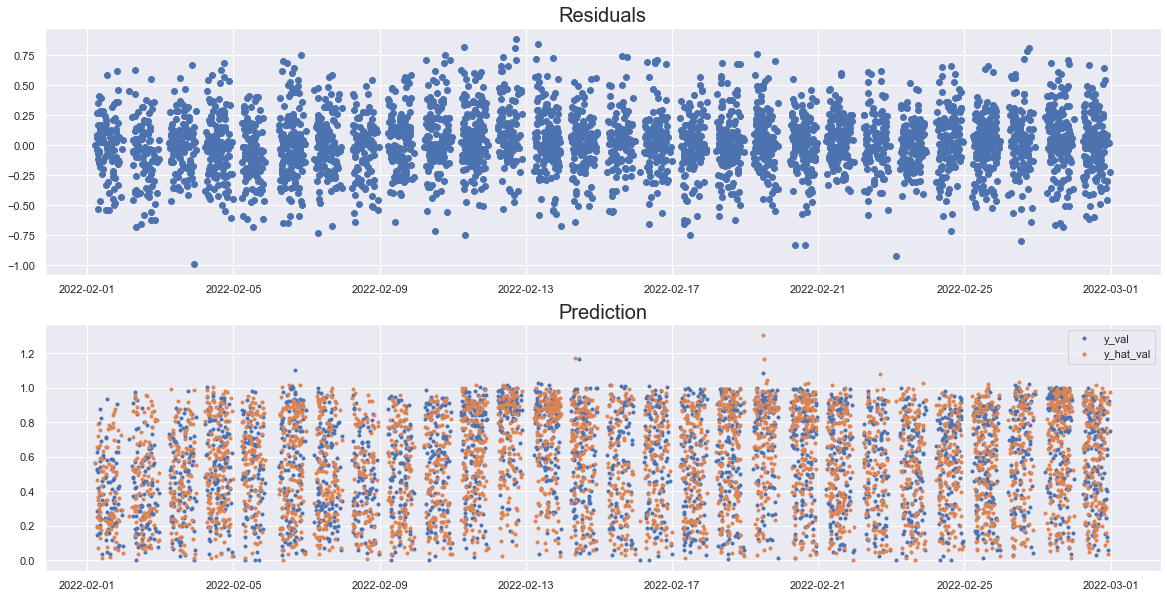

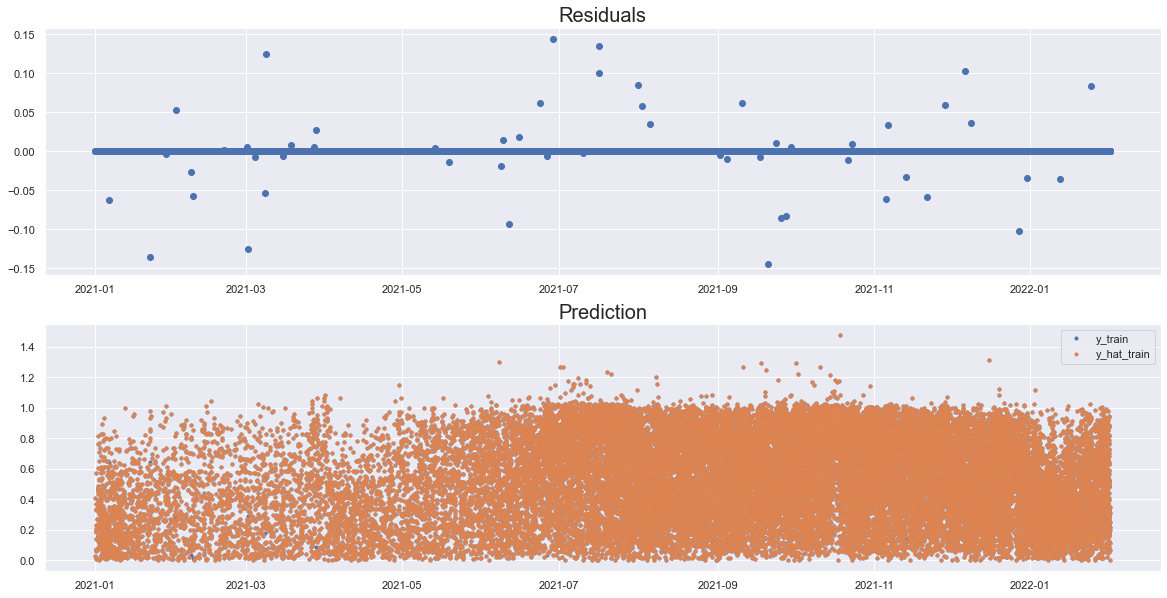

In [32]:
model = tree.DecisionTreeRegressor(min_samples_leaf = 1)#, ccp_alpha = n)
model.fit(X_train,y_train)
yhat = model.predict(X_val)
yhat_train = model.predict(X_train)


model_err = np.mean(abs(y_val - yhat))
print(f'Model absolute error: {model_err}')

baseline_err = abs(y_val - train_data[train_data['ScheduleTime']>'2022-01-01'].LoadFactor.mean()).mean()
print(f'Baseline error: {baseline_err}')

fig, ax = plt.subplots(2,1, figsize = (20,10))
plt.title('Validation data')
ax[0].scatter(val_data.ScheduleTime, y_val - yhat)
ax[0].set_title('Residuals',fontsize = 20)

ax[1].plot(val_data.ScheduleTime, y_val,'.', label = 'y_val')
ax[1].plot(val_data.ScheduleTime, yhat,  '.', label = 'y_hat_val',)
ax[1].set_title('Prediction',fontsize = 20 )
ax[1].legend()


fig, ax = plt.subplots(2,1, figsize = (20,10))
plt.title('Training data')
ax[0].scatter(train_data.ScheduleTime, y_train - yhat_train)
ax[0].set_title('Residuals',fontsize = 20)

ax[1].plot(train_data.ScheduleTime, y_train,'.', label = 'y_train')
ax[1].plot(train_data.ScheduleTime, yhat_train,  '.', label = 'y_hat_train')
ax[1].set_title('Prediction',fontsize = 20 )
ax[1].legend()

plt.show()

In [33]:
# random forrest
forest = ensemble.RandomForestRegressor(n_estimators = 10)
forest.fit(X_train,y_train)
yhat = forest.predict(X_val)


model_err = np.mean(abs(y_val - yhat))
print(f'Forest absolute error: {model_err}')


Forest absolute error: 0.14529106809684852


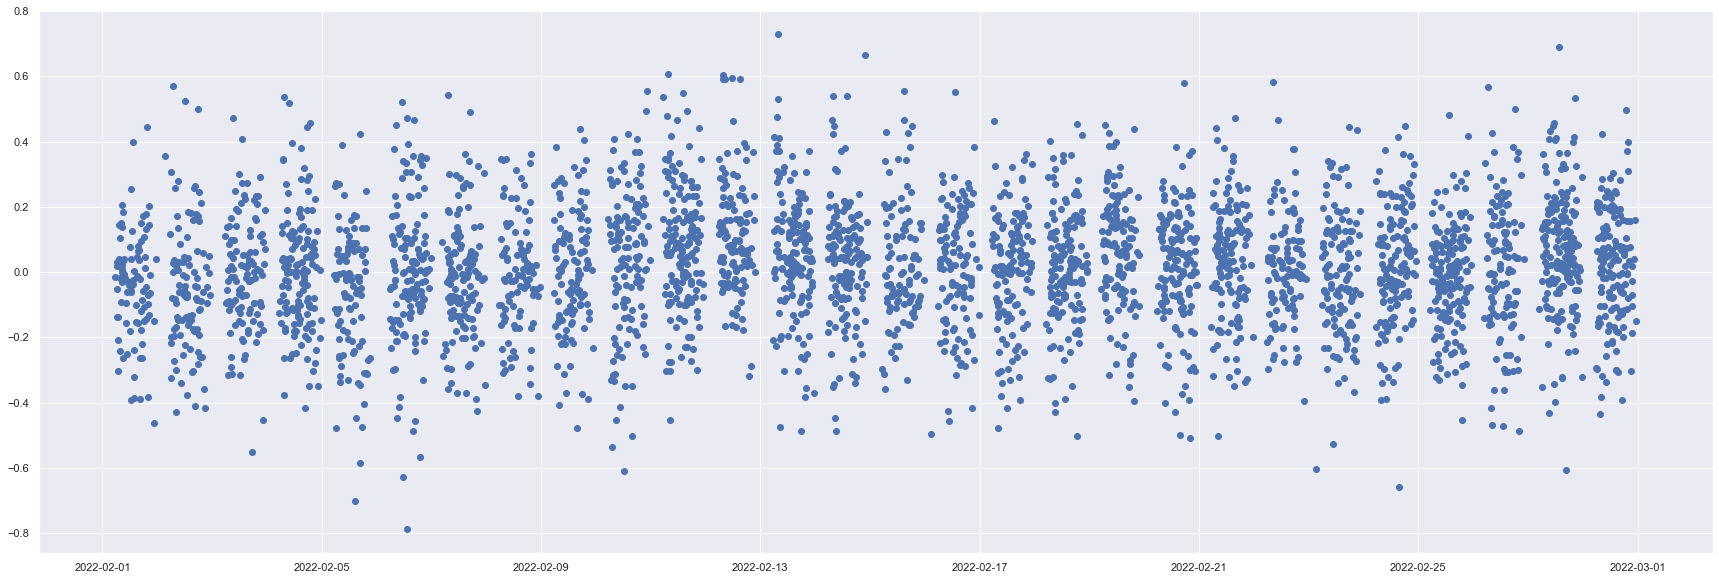

In [34]:
fig, ax = plt.subplots(1,1, figsize = (30,10))
ax.scatter(val_data.ScheduleTime, y_val - yhat)

In [35]:
#n_leafs = np.arange(1,30)
#ccps = np.linspace(0,0.5, 10)

#err = []
#for n in ccps:
#    model = tree.DecisionTreeRegressor(min_samples_leaf = 10, ccp_alpha = n)
#    model.fit(X_train,y_train)
#    yhat = model.predict(X_val)

#    err.append(np.mean(abs(y_val - yhat)))